# PM10 Forecasting Pipeline (Multi-Target)

This repository contains the code to perform multi-target time series forecasting of PM10 levels across various locations in Canton Ticino using meteorological data and historical pollutant measurements.

# Forecasting pipeline


1. **Data pre-processing and EDA**
    1.  Missing values detection and imputation
    2.  Outliers detection and treatment
    3.  Seasonality and trend analysis
    4.  Stationarity tests
    5.  Correlation analysis between locations and signals
2.  **Univariate benchmark models**
    1.  naive methods
    2.  Holt-Winters, AR(I)MAX
3.  **Model proposal and training**
    1.  Cross-validation functions
    2.  Hyperparameter tuning strategies
    3.  RNN dense, GRU and Informer models
4.  **Model evaluation**
    1.  Evaluation on the test set
    2.  Comparison with benchmark models
5.  **Forecast visualization** 
    1.  Visualization of the forecasts for each location and horizon
    2.  Visualization of the average forecast across locations
---
Understanding the relations between weather conditions and inquinants like ozone and PM10, PM2.5 is important to take in place systemic counter-measures to increase air quality.

This dataset contains measurements of PM10, chemical components and meteorological forecasts at different hours of the day related to various locations of Canton Ticino.

The dataset refers to the period 2016-2022 and has been provided by [OASI](https://www.oasi.ti.ch/web/esplora-dati/). The forecasted weather conditions have been obtained through the [COSMO and COSMO2 models](https://www.notion.so/fd5a606c07144109bc080ec595f6295d?pvs=21), which is tune to produce accurate forecasts in the topographically challenging Alpine region.

The following tables summarize the name of the variables and locations present in the dataset: The naming convention in the dataset is the following:

- $LOCATION__$SIGNAL__$HOUR for measurements
- $LOCATION__$SIGNAL__$STEP for meteorological forecasts
- $LOCATION__$SIGNAL__$DAY_AHEAD for the target

---
## Challenge:

The task is to produce the 1-6 days ahead forecasts of the daily mean of the PM10 quantity (already provided in the last columns of the dataset, e.g. BRI__YPM10-dailymean__d3 for the 3 days ahead value in Brione) **for all the provided locations AND their average**.

# Libraries and functions import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

1. **Data pre-processing and EDA**
    3.  Seasonality and trend analysis
    4.  Stationarity tests
    5.  Correlation analysis between locations and signals

## 1 - Data Loading and Overview

In [2]:
df = pd.read_csv('archive/data.csv', index_col='date', parse_dates=True)
print(f"Data shape: {df.shape}")
print(f"Columns: {len(df.columns)} columns")
print(f"Date range: {df.index.min()} to {df.index.max()}")

Data shape: (2557, 8536)
Columns: 8536 columns
Date range: 2016-01-01 00:00:00 to 2022-12-31 00:00:00


## 1 - Target and Features Extraction

In [3]:
target_name = "YPM10-dailymean"

target_cols = [col for col in df.columns if target_name in col]
features_cols = [col for col in df.columns if target_name not in col]
print(f"Target columns: {len(target_cols)}")
print(f"Feature columns: {len(features_cols)}")


Target columns: 48
Feature columns: 8488


## 1 - Get locations


In [4]:
locations = sorted(list(set([c.split('__')[0] for c in target_cols])))
print(f"Locations: {locations}")

Locations: ['BIO', 'BRI', 'CHI', 'GIU', 'LOC', 'LUG', 'MEN', 'NA-MAG']


## 1. Calculate average 

The challenge asked to predict the average PM10 levels across all locations. To do so, we calculate the mean of the PM10 values for each time step.

In [5]:
days_ahead = sorted(list(set([c.split('__')[-1] for c in target_cols]))) # e.g., ['d0', 'd1', ..., 'd5']
print(f"Days ahead: {days_ahead}")

Days ahead: ['d0', 'd1', 'd2', 'd3', 'd4', 'd5']


In [6]:
X_train = df[features_cols]
Y_train = df[target_cols]
y_avg = pd.DataFrame(index=Y_train.index)

for day in days_ahead:
    # Find all columns for the current day
    day_cols = [col for col in target_cols if col.endswith(f'__{day}')]
    avg_col_name = f"AVG__YPM10-dailymean__{day}"
    y_avg[avg_col_name] = Y_train[day_cols].mean(axis=1)
    print(f"processed: {avg_col_name}")


processed: AVG__YPM10-dailymean__d0
processed: AVG__YPM10-dailymean__d1
processed: AVG__YPM10-dailymean__d2
processed: AVG__YPM10-dailymean__d3
processed: AVG__YPM10-dailymean__d4
processed: AVG__YPM10-dailymean__d5


In [7]:
y_train = pd.concat([Y_train, y_avg], axis=1)
print(f"y_train shape after adding averages: {y_train.shape}")

y_train shape after adding averages: (2557, 54)


In [8]:
forecast_features = [col for col in features_cols if '__m']
#extract only in between #check uniqueness of pollutants in forecast features
pollutants = set()
for col in forecast_features:
    pollutant = col.split('__')[1]
    pollutants.add(pollutant)
print(f"Pollutants in forecast features: {pollutants}")

Pollutants in forecast features: {'TOT_PREC', 'NO2', 'RH', 'NOx', 'CN', 'TD_2M_c2', 'Prec', 'Tdew', 'PM10', 'D_T_T', 'RELHUM_2M_c2', 'P', 'CLCT_c2', 'O3', 'FF_10M', 'GLOB_c2', 'D_P_P', 'DD_10M', 'WDvect', 'TOT_PREC_c2', 'WD', 'WS', 'PS', 'TD_2M', 'T_2M_c2', 'WSgust', 'RELHUM_2M', 'PS_c2', 'NO', 'Gl', 'PM2.5', 'GLOB', 'T_2M', 'T', 'WSvect', 'CLCT'}


## 1. Feature Explanations

The dataset's features include historical measurements and meteorological data across various locations in Canton Ticino. The "pollutants" (or signals) extracted from the forecast features are a mix of air pollutants and weather variables, all with lagged versions (e.g., m0 for current, m1 for 1 step back). Below is an explanation of each signal based on standard air quality and meteorological conventions. Note that these are inputs for predicting PM10 levels, and the exact units/definitions may vary slightly by dataset source (OASI/COSMO models).

| Signal | Full Name/Description |
|--------|-----------------------|
| WSgust | Wind Speed Gust – Maximum short-term wind speed, indicating potential for pollutant dispersion or advection. |
| O3     | Ozone – A secondary pollutant formed by chemical reactions; high levels can indicate photochemical smog and affect air quality. |
| CN     | Carbon Monoxide? (or possibly another carbon-based pollutant) – Likely a measure of carbon monoxide or a related compound; toxic gas from combustion. |
| WDvect | Wind Direction Vector – Vector representation of wind direction (e.g., x/y components), useful for modeling wind patterns. |
| D_T_T  | Temperature Difference (possibly dew point or gradient) – Difference in temperature values, potentially between surface and air or over time. |
| Prec   | Precipitation – Amount of rainfall or snow, which can wash out pollutants or influence humidity. |
| T      | Temperature – Air temperature, a key meteorological factor affecting pollutant formation and dispersion. |
| D_P_P  | Pressure Difference – Gradient or change in atmospheric pressure, influencing weather systems and pollutant transport. |
| RH     | Relative Humidity – Percentage of moisture in the air, impacting pollutant reactions and health effects. |
| WSvect | Wind Speed Vector – Vector representation of wind speed (e.g., u/v components), for directional wind modeling. |
| NO     | Nitrogen Monoxide – Primary pollutant from vehicle emissions; precursor to NO2 and ozone. |
| NO2    | Nitrogen Dioxide – Toxic gas from combustion; contributes to acid rain and respiratory issues. |
| Gl     | Global Radiation – Incoming solar radiation, influencing photochemical reactions like ozone formation. |
| Tdew   | Dew Point Temperature – Temperature at which air becomes saturated; indicates humidity levels. |
| WS     | Wind Speed – Average wind speed, affecting pollutant dilution and transport. |
| WD     | Wind Direction – Direction from which the wind blows, important for source attribution of pollutants. |
| NOx    | Nitrogen Oxides – Combined NO and NO2; indicator of traffic-related pollution. |
| PM10   | Particulate Matter ≤10 μm – Coarse particulate matter; included as historical lags for autoregressive forecasting. |
| P      | Atmospheric Pressure – Barometric pressure, influencing weather stability and pollutant accumulation. |

These features are lagged (e.g., __m0 to __m20) to capture temporal dependencies. Meteorological signals (e.g., T, RH, WS) are often more complete. For modeling, they help predict PM10 by incorporating weather influences and historical pollutant trends. 

## 1. Feature visualization

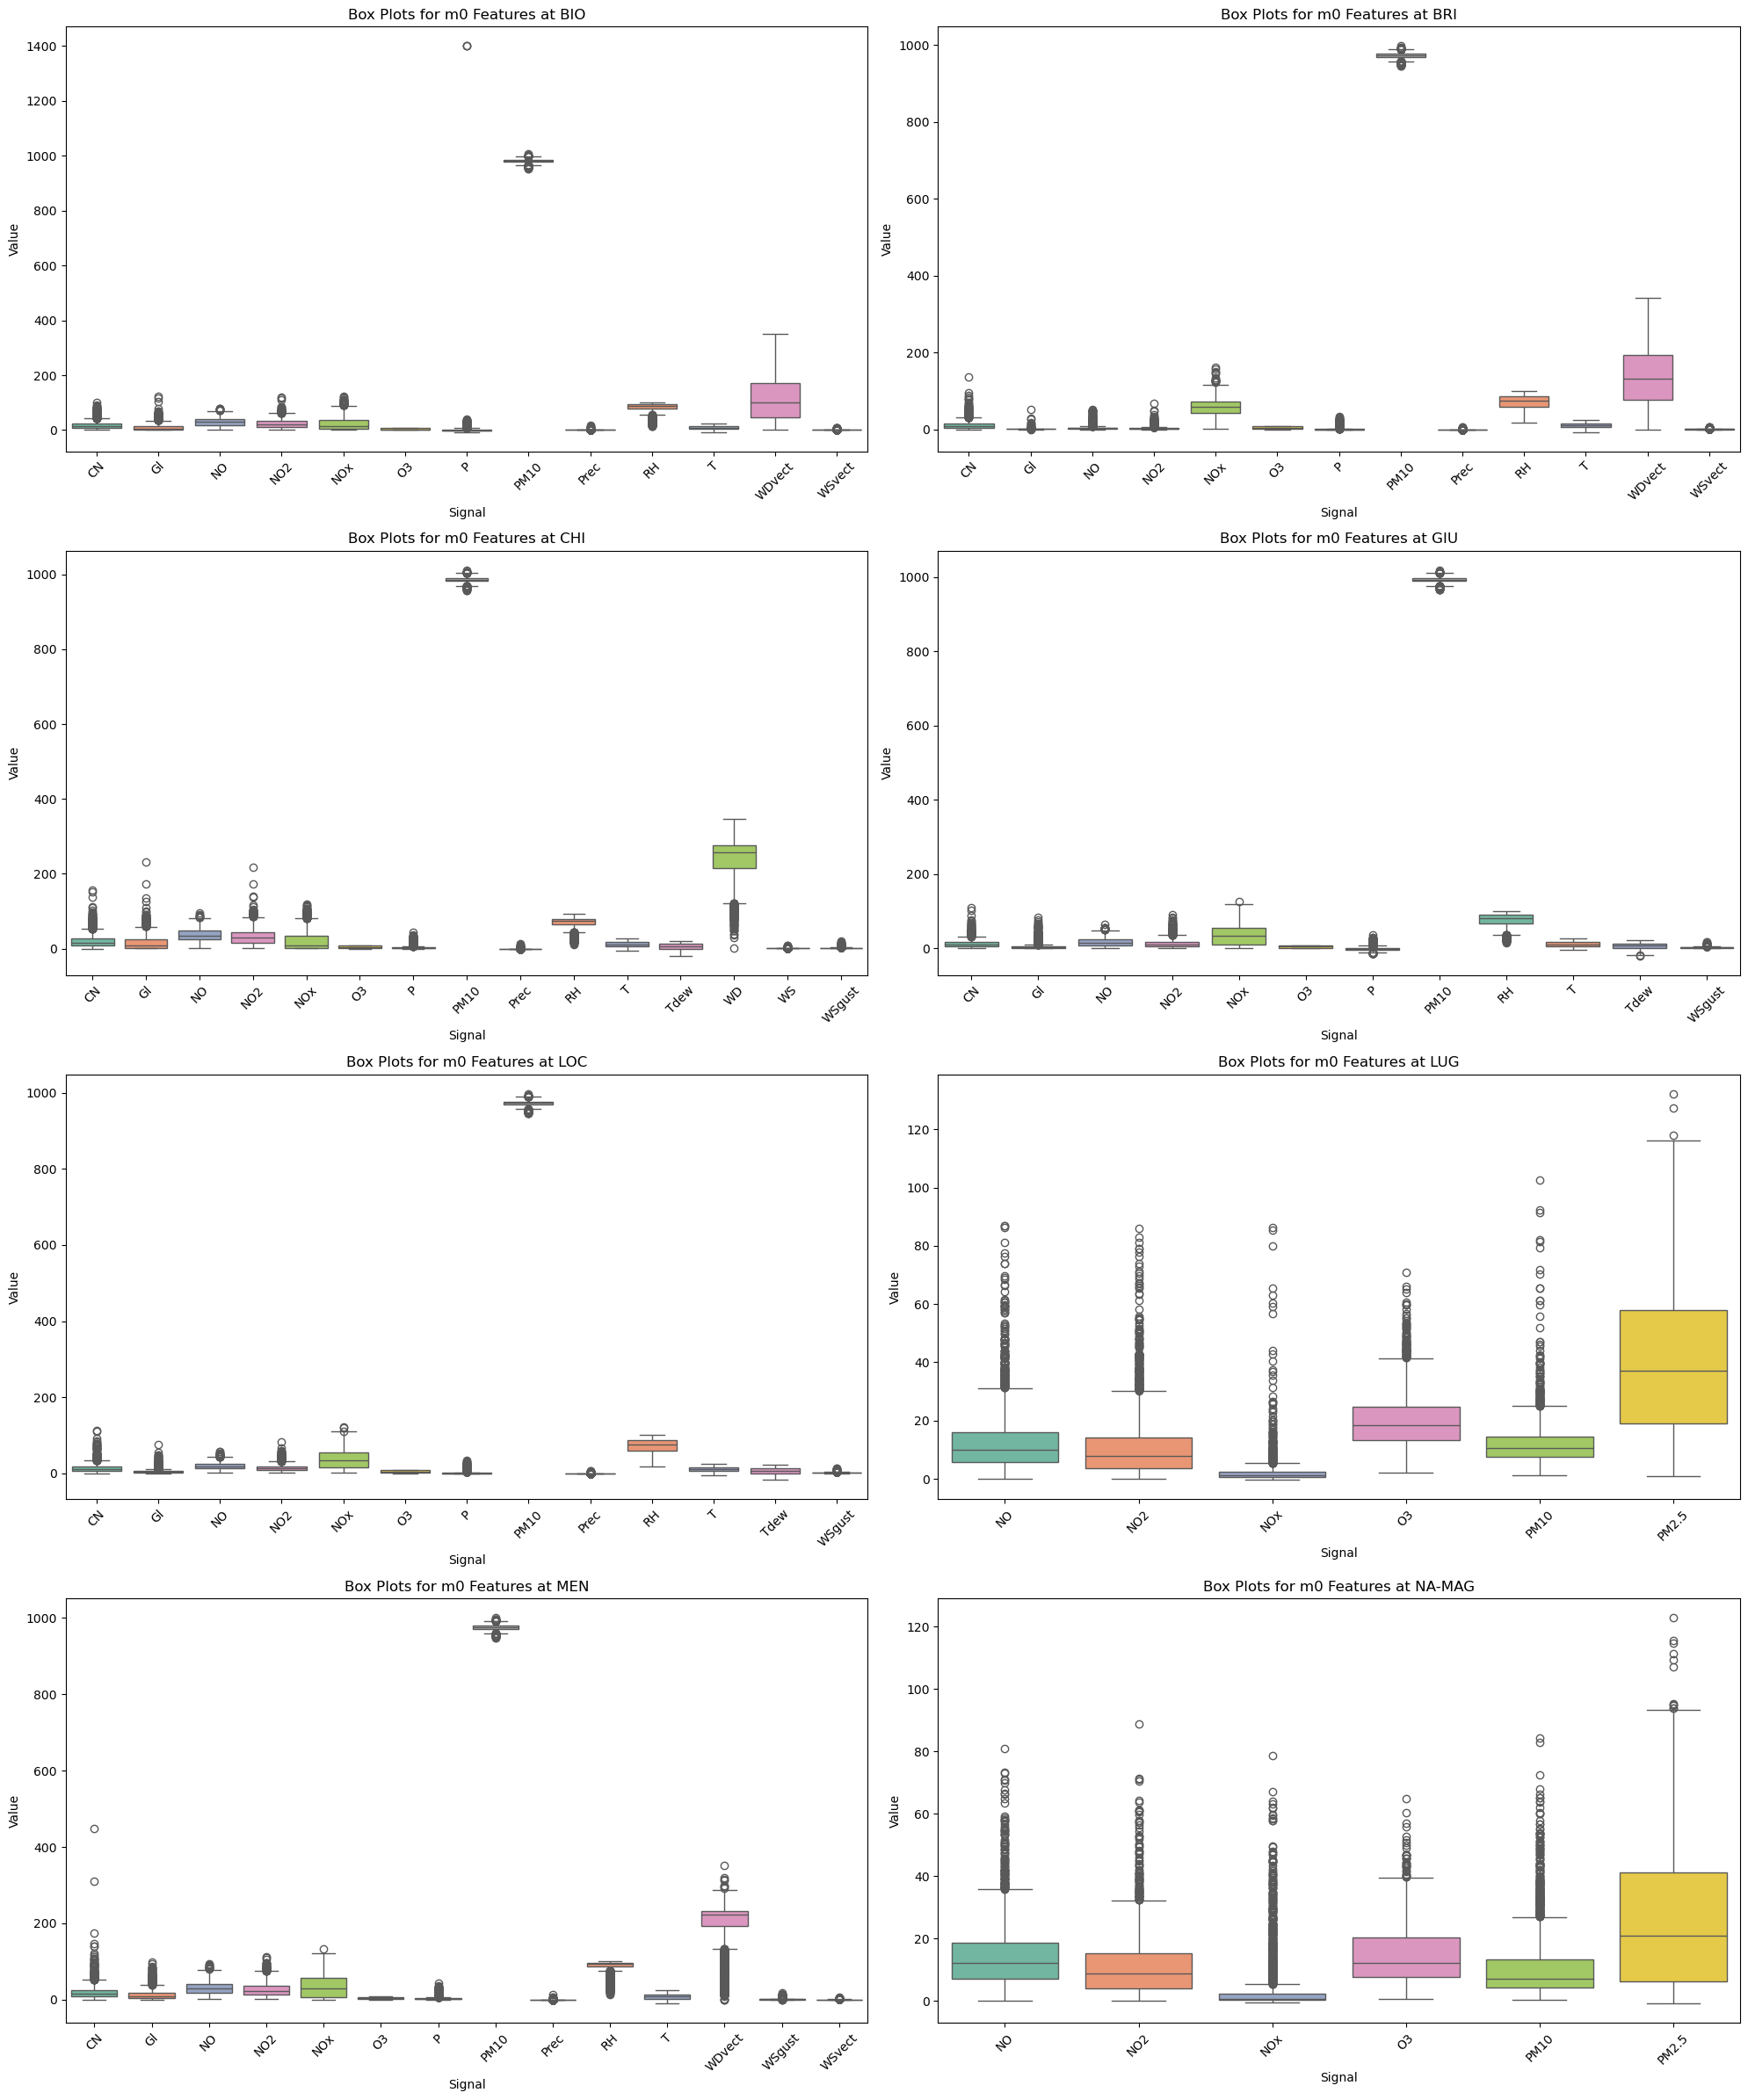

In [9]:
#Feature boxplots, x axis the feature, 1 plot for location
m0_features = [col for col in features_cols if col.endswith('__m0')]

fig, axes = plt.subplots(4, 2, figsize=(20, 24))
axes = axes.flatten()

for i, loc in enumerate(locations):
    ax = axes[i]
    loc_features = [col for col in m0_features if col.startswith(f'{loc}__')]
    if loc_features:
        signals = sorted([col.split('__')[1] for col in loc_features])
        data = X_train[loc_features].copy()
        data.columns = signals
        melted = data.melt(var_name='Signal', value_name='Value')
        sns.boxplot(data=melted, x='Signal', y='Value', ax=ax, hue='Signal', palette='Set2', legend=False)
        ax.set_title(f'Box Plots for m0 Features at {loc}')
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

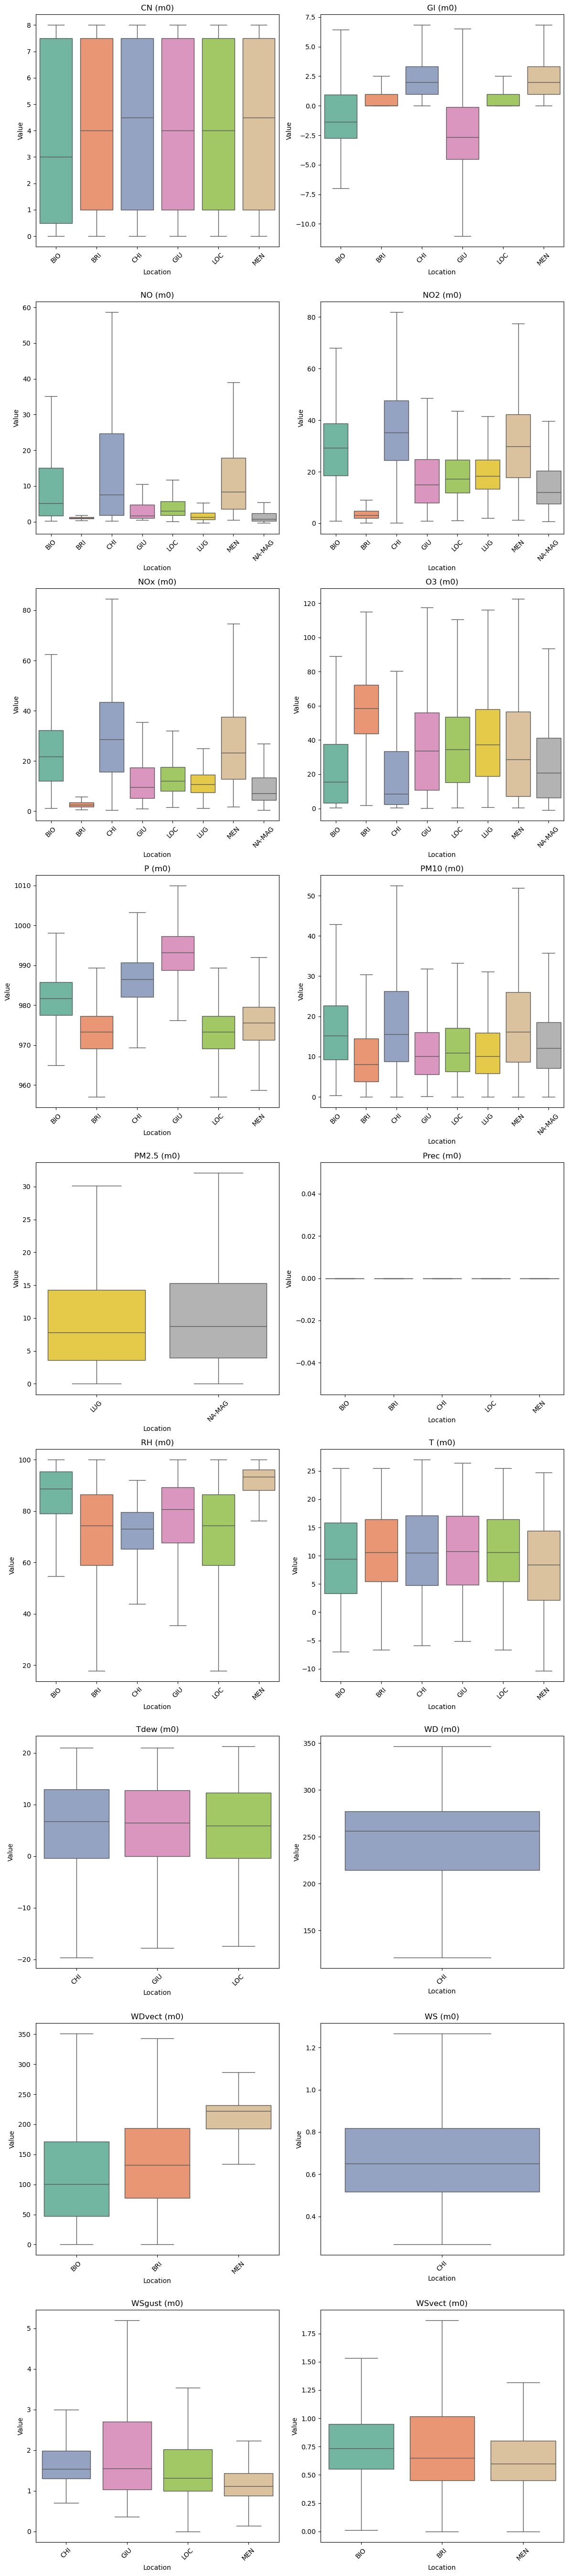

In [10]:
# Box plots per feature (signal) with all locations on the same chart in a 2x10 grid
m0_features = [col for col in features_cols if col.endswith('__m0')]

# Get all unique signals across locations that have data
all_signals = []
for signal in sorted(set([col.split('__')[1] for col in m0_features])):
    has_data = False
    for loc in locations:
        col_name = f'{loc}__{signal}__m0'
        if col_name in X_train.columns and not X_train[col_name].dropna().empty:
            has_data = True
            break
    if has_data:
        all_signals.append(signal)

# Define consistent color palette for locations
location_palette = {loc: color for loc, color in zip(sorted(locations), sns.color_palette('Set2', len(locations)))}

# Adjust grid size based on number of signals
n_signals = len(all_signals)
n_cols = 2
n_rows = (n_signals + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6 * n_rows))
axes = axes.flatten()

for i, signal in enumerate(all_signals):
    ax = axes[i]
    # Collect data for this signal across all locations
    signal_data = []
    location_labels = []
    for loc in locations:
        col_name = f'{loc}__{signal}__m0'
        if col_name in X_train.columns:
            data = X_train[col_name].dropna()
            if not data.empty:
                signal_data.append(data)
                location_labels.extend([loc] * len(data))
    
    # Combine into a DataFrame for plotting
    combined_data = pd.DataFrame({
        'Value': pd.concat(signal_data),
        'Location': location_labels
    })
    
    # Sort by location for consistent order
    combined_data = combined_data.sort_values('Location')
    
    sns.boxplot(data=combined_data, x='Location', y='Value', ax=ax, hue='Location', palette=location_palette, legend=False, showfliers=False)
    ax.set_title(f'{signal} (m0)')
    ax.tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(n_signals, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

NA-MAG and LUG seems to be different stations with a different set of features, possibly due to their specific measurement setups or data availability and not all the stations have all the features listed above.

In [11]:
# Features per station (m0 measurements)
features_per_station = {}
for loc in locations:
    loc_features = [col for col in m0_features if col.startswith(f'{loc}__')]
    signals = sorted([col.split('__')[1] for col in loc_features])
    features_per_station[loc] = signals

for loc, signals in features_per_station.items():
    print(f"{loc}: {signals}")

#common features across all stations
common_features = set(features_per_station[locations[0]])
for loc in locations[1:]:
    common_features.intersection_update(set(features_per_station[loc]))
print(f"Common features across all stations: {sorted(common_features)}")

BIO: ['CN', 'Gl', 'NO', 'NO2', 'NOx', 'O3', 'P', 'PM10', 'Prec', 'RH', 'T', 'WDvect', 'WSvect']
BRI: ['CN', 'Gl', 'NO', 'NO2', 'NOx', 'O3', 'P', 'PM10', 'Prec', 'RH', 'T', 'WDvect', 'WSvect']
CHI: ['CN', 'Gl', 'NO', 'NO2', 'NOx', 'O3', 'P', 'PM10', 'Prec', 'RH', 'T', 'Tdew', 'WD', 'WS', 'WSgust']
GIU: ['CN', 'Gl', 'NO', 'NO2', 'NOx', 'O3', 'P', 'PM10', 'RH', 'T', 'Tdew', 'WSgust']
LOC: ['CN', 'Gl', 'NO', 'NO2', 'NOx', 'O3', 'P', 'PM10', 'Prec', 'RH', 'T', 'Tdew', 'WSgust']
LUG: ['NO', 'NO2', 'NOx', 'O3', 'PM10', 'PM2.5']
MEN: ['CN', 'Gl', 'NO', 'NO2', 'NOx', 'O3', 'P', 'PM10', 'Prec', 'RH', 'T', 'WDvect', 'WSgust', 'WSvect']
NA-MAG: ['NO', 'NO2', 'NOx', 'O3', 'PM10', 'PM2.5']
Common features across all stations: ['NO', 'NO2', 'NOx', 'O3', 'PM10']


## 1. Correlation analysis (measurements) for the next day PM10 target

In [12]:
# Correlation analysis between features and target per station
# Select target time horizon (d0, d1, d2, d3, d4, d5)
target_horizon = 'd0'  # Change this to desired horizon

print(f"Correlation analysis for target horizon: {target_horizon}")
print("="*60)

# Store correlations for each station
station_correlations = {}

for loc in locations:
    # Get target column for this location and horizon
    target_col = f"{loc}__YPM10-dailymean__{target_horizon}"
    
    if target_col not in y_train.columns:
        print(f"Warning: {target_col} not found in targets")
        continue
    
    # Get m0 features for this location
    loc_features = [col for col in m0_features if col.startswith(f'{loc}__')]
    
    if not loc_features:
        continue
    
    # Calculate correlations
    correlations = {}
    for feat_col in loc_features:
        signal = feat_col.split('__')[1]
        # Calculate correlation, handling NaN values
        corr = X_train[feat_col].corr(y_train[target_col])
        if not pd.isna(corr):
            correlations[signal] = corr
    
    # Sort by absolute correlation value
    correlations = dict(sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True))
    station_correlations[loc] = correlations
    
    # # Print results
    # print(f"\n{loc}:")
    # print("{", end="")
    # for i, (signal, corr) in enumerate(correlations.items()):
    #     if i > 0:
    #         print(", ", end="")
    #     print(f"'{signal}': {corr:.3f}", end="")
    # print("}")


Correlation analysis for target horizon: d0


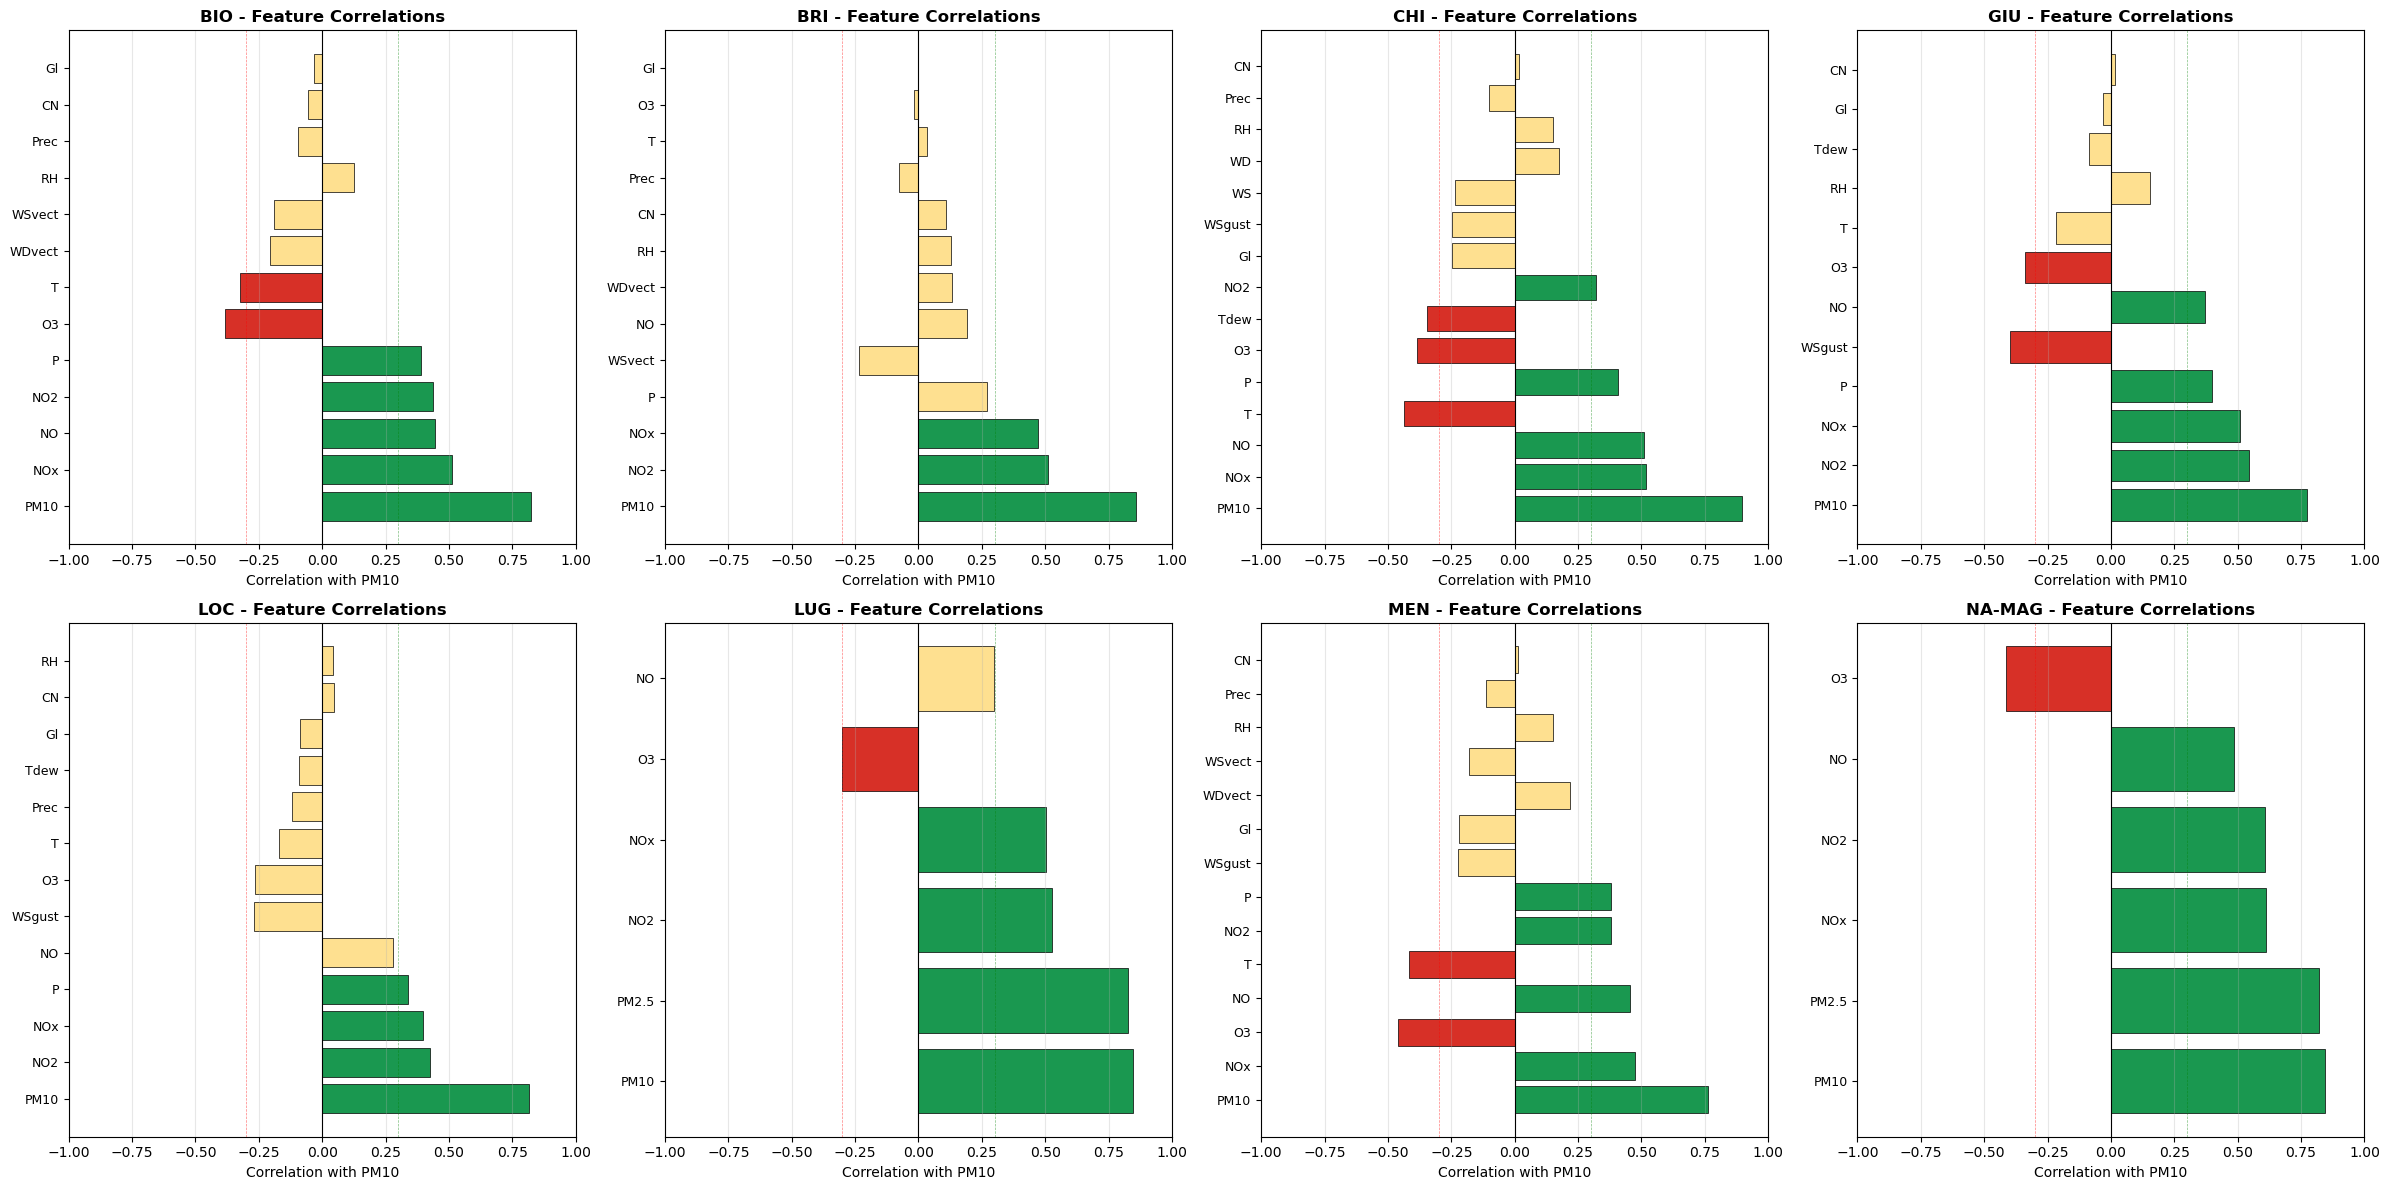


Correlation Heatmap Across All Stations


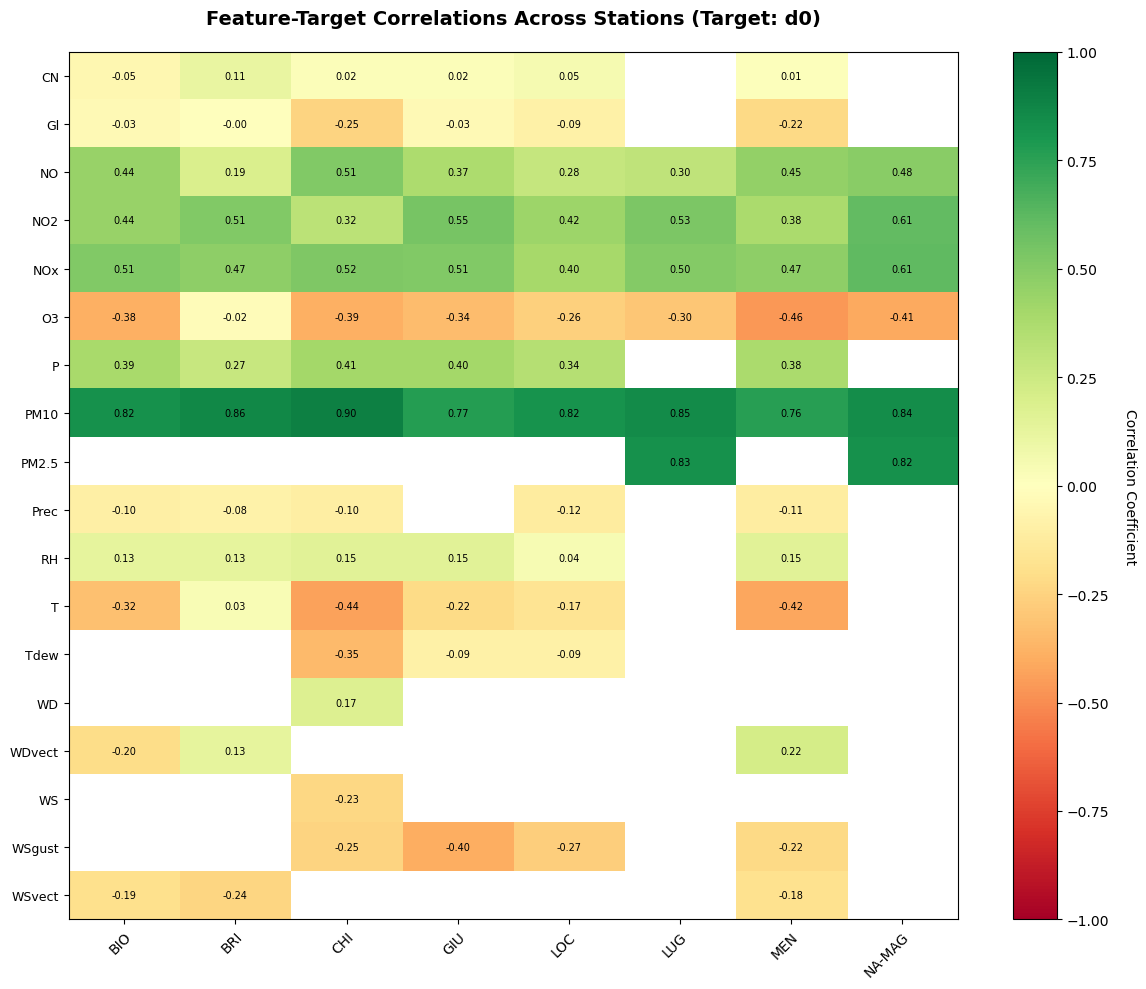

In [13]:
# Creative visualization of feature-target correlations
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a heatmap of correlations across all stations
fig, axes = plt.subplots(2, 4, figsize=(24, 12))
axes = axes.flatten()

for i, loc in enumerate(locations):
    ax = axes[i]
    
    if loc not in station_correlations:
        ax.set_visible(False)
        continue
    
    corrs = station_correlations[loc]
    signals = list(corrs.keys())
    values = list(corrs.values())
    
    # Create color map based on correlation strength
    colors = ['#d73027' if v < -0.3 else '#fee090' if abs(v) < 0.3 else '#1a9850' for v in values]
    
    # Horizontal bar chart
    y_pos = np.arange(len(signals))
    bars = ax.barh(y_pos, values, color=colors, edgecolor='black', linewidth=0.5)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(signals, fontsize=9)
    ax.set_xlabel('Correlation with PM10', fontsize=10)
    ax.set_title(f'{loc} - Feature Correlations', fontsize=12, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax.axvline(x=0.3, color='green', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.axvline(x=-0.3, color='red', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.set_xlim(-1, 1)
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Heatmap across all stations
print("\n" + "="*60)
print("Correlation Heatmap Across All Stations")
print("="*60)

# Get all unique signals
all_signals_set = set()
for corrs in station_correlations.values():
    all_signals_set.update(corrs.keys())
all_signals_sorted = sorted(all_signals_set)

# Create correlation matrix
corr_matrix = np.zeros((len(all_signals_sorted), len(locations)))
corr_matrix[:] = np.nan

for j, loc in enumerate(locations):
    if loc in station_correlations:
        for i, signal in enumerate(all_signals_sorted):
            if signal in station_correlations[loc]:
                corr_matrix[i, j] = station_correlations[loc][signal]

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(corr_matrix, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)

# Set ticks
ax.set_xticks(np.arange(len(locations)))
ax.set_yticks(np.arange(len(all_signals_sorted)))
ax.set_xticklabels(locations, fontsize=10)
ax.set_yticklabels(all_signals_sorted, fontsize=9)

# Rotate x labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20)

# Add text annotations
for i in range(len(all_signals_sorted)):
    for j in range(len(locations)):
        if not np.isnan(corr_matrix[i, j]):
            text = ax.text(j, i, f'{corr_matrix[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=7)

ax.set_title(f'Feature-Target Correlations Across Stations (Target: {target_horizon})', 
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [14]:
#mean correlation per feature across all stations
mean_correlations = {}
for signal in all_signals_sorted:
    vals = []
    for loc in locations:
        if loc in station_correlations and signal in station_correlations[loc]:
            vals.append(station_correlations[loc][signal])
    if vals:
        mean_correlations[signal] = np.mean(vals)
# Print mean correlations
print("\n" + "="*60)
print("Mean Correlation per Feature Across All Stations")
print("="*60)
for signal, mean_corr in sorted(mean_correlations.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"'{signal}': {mean_corr:.3f}")

#interesect with common features
print("\n" + "="*60)
print("Mean Correlation for Common Features Across All Stations")
print("="*60)
for signal in sorted(common_features):
    if signal in mean_correlations:
        print(f"'{signal}': {mean_correlations[signal]:.3f}")

#non common features mean correlations
print("\n" + "="*60)
print("Mean Correlation for Non-Common Features Across All Stations")
print("="*60)
for signal, mean_corr in sorted(mean_correlations.items(), key=lambda x: abs(x[1]), reverse=True):
    if signal not in common_features:
        print(f"'{signal}': {mean_corr:.3f}") 


Mean Correlation per Feature Across All Stations
'PM10': 0.827
'PM2.5': 0.823
'NOx': 0.500
'NO2': 0.469
'NO': 0.379
'P': 0.363
'O3': -0.321
'WSgust': -0.284
'T': -0.255
'WS': -0.234
'WSvect': -0.202
'Tdew': -0.176
'WD': 0.174
'RH': 0.125
'Gl': -0.104
'Prec': -0.102
'WDvect': 0.048
'CN': 0.025

Mean Correlation for Common Features Across All Stations
'NO': 0.379
'NO2': 0.469
'NOx': 0.500
'O3': -0.321
'PM10': 0.827

Mean Correlation for Non-Common Features Across All Stations
'PM2.5': 0.823
'P': 0.363
'WSgust': -0.284
'T': -0.255
'WS': -0.234
'WSvect': -0.202
'Tdew': -0.176
'WD': 0.174
'RH': 0.125
'Gl': -0.104
'Prec': -0.102
'WDvect': 0.048
'CN': 0.025


The common features might be enough to have a good predictive performance, if we find some heavy missingness in some of the uncommon features we might consider dropping them altogether, and impute only the common ones.

## 1. Correlation analysis (forecast) for the next day PM10 target

## Forecast Feature Explanations

The forecast features come from **COSMO meteorological models** (COSMO and COSMO-2), which provide weather predictions for the Alpine region. These are **multi-day ahead forecasts** (step0 to step5) that can be used to predict future PM10 levels.

### Base COSMO Model Features

| Signal | Full Name/Description | Relevance to PM10 |
|--------|----------------------|-------------------|
| **T_2M** | Temperature at 2 meters | Higher temperatures can increase PM10 through resuspension and secondary aerosol formation |
| **TD_2M** | Dew Point Temperature at 2m | Indicates humidity; high humidity can trap pollutants near ground level |
| **RELHUM_2M** | Relative Humidity at 2m | High RH reduces dispersion; low RH increases dust resuspension |
| **FF_10M** | Wind Speed at 10 meters | Higher wind speeds disperse pollutants; calm conditions trap PM10 |
| **DD_10M** | Wind Direction at 10m | Indicates pollutant transport direction from source regions |
| **PS** | Surface Pressure | High pressure = stable conditions = poor dispersion; low pressure = better mixing |
| **GLOB** | Global Solar Radiation | Strong radiation drives photochemistry and vertical mixing |
| **TOT_PREC** | Total Precipitation | Rain washes out PM10 (wet deposition); reduces concentrations |
| **CLCT** | Total Cloud Cover | Affects radiation, temperature gradients, and mixing layer height |

### COSMO-2 High-Resolution Features (`_c2` suffix)

The features with **`_c2`** suffix come from the **COSMO-2 model**, which provides:
- **Higher spatial resolution** (~2.2 km vs ~7 km for COSMO)
- **Better representation of Alpine topography** (mountains, valleys)
- **More accurate forecasts for complex terrain**

Examples:
- `T_2M_c2`: High-resolution temperature forecast
- `TOT_PREC_c2`: Fine-scale precipitation patterns
- `PS_c2`: Localized pressure systems

### Key Meteorological Relationships

**Temperature (T_2M, TD_2M)**
- ↑ Temperature → ↑ PM10 (resuspension, secondary formation)
- Large T_2M - TD_2M gap → Low humidity → More dust

**Wind (FF_10M, DD_10M)**
- ↑ Wind speed → ↓ PM10 (dispersion)
- Wind direction determines if pollution arrives from industrial/urban areas

**Pressure (PS)**
- High pressure systems → Temperature inversions → Trapped pollutants
- Low pressure → Vertical mixing → Better air quality

**Precipitation (TOT_PREC)**
- Rain → Washout effect → ↓ PM10
- Most effective PM10 removal mechanism

**Radiation & Clouds (GLOB, CLCT)**
- Strong radiation → Convective mixing → Disperses PM10
- Clouds → Reduced mixing → Can trap pollutants

### Forecast Horizons (step0 to step5)

- **step0**: Current day forecast (0 days ahead)
- **step1**: Tomorrow's forecast (1 day ahead)
- **step2-step5**: 2-5 days ahead forecasts

**Expected behavior**: Correlations should be strongest on the diagonal (step0→d0, step1→d1, etc.) as forecast quality degrades with time.

FORECAST FEATURE CORRELATION ANALYSIS - IDENTIFYING MOST RELEVANT FEATURES

Analyzing 16 forecast signals:
['CLCT', 'CLCT_c2', 'DD_10M', 'FF_10M', 'GLOB', 'GLOB_c2', 'PS', 'PS_c2', 'RELHUM_2M', 'RELHUM_2M_c2', 'TD_2M', 'TD_2M_c2', 'TOT_PREC', 'TOT_PREC_c2', 'T_2M', 'T_2M_c2']


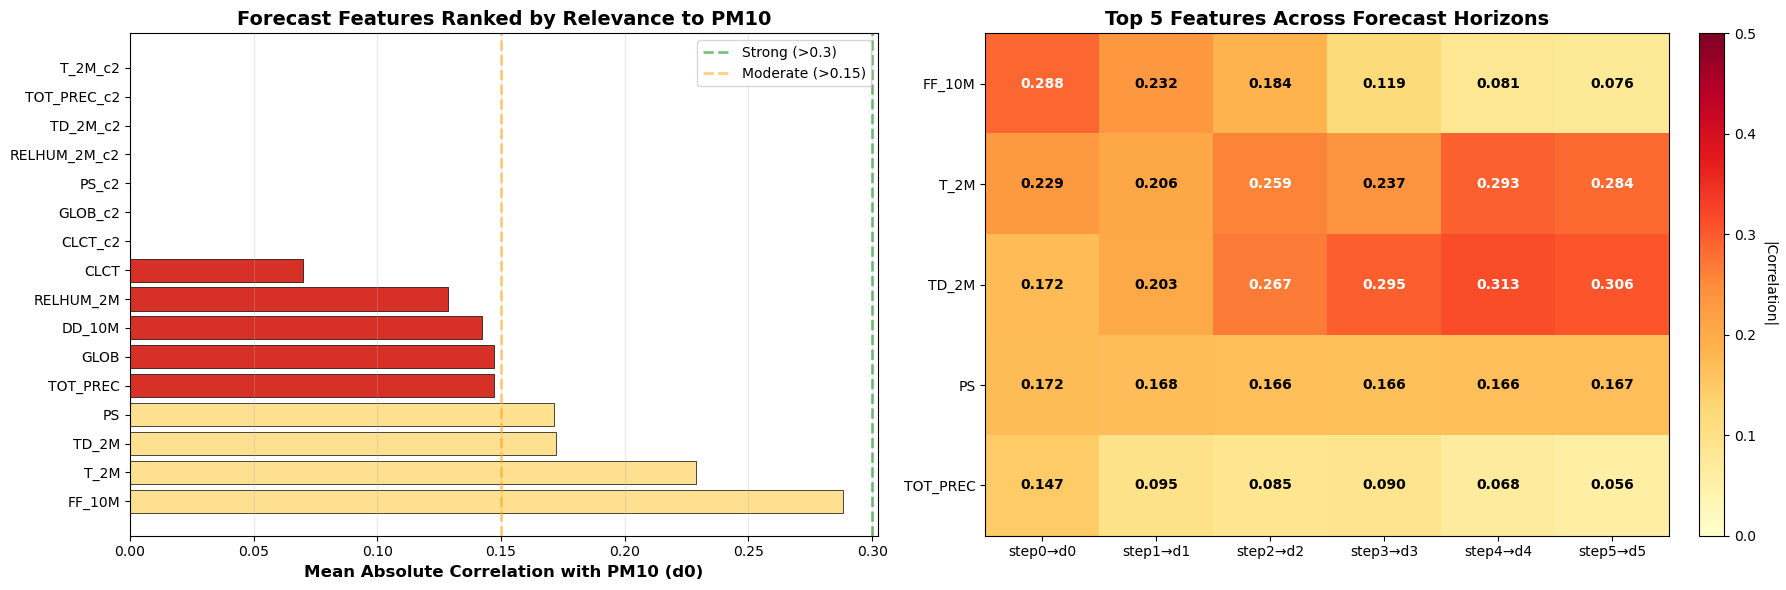


FORECAST FEATURE RANKING (step0→d0 correlation with PM10)
 1. FF_10M          → 0.2880 (MODERATE)
 2. T_2M            → 0.2289 (MODERATE)
 3. TD_2M           → 0.1724 (MODERATE)
 4. PS              → 0.1716 (MODERATE)
 5. TOT_PREC        → 0.1472 (WEAK)
 6. GLOB            → 0.1471 (WEAK)
 7. DD_10M          → 0.1425 (WEAK)
 8. RELHUM_2M       → 0.1286 (WEAK)
 9. CLCT            → 0.0698 (WEAK)
10. CLCT_c2         → 0.0000 (WEAK)
11. GLOB_c2         → 0.0000 (WEAK)
12. PS_c2           → 0.0000 (WEAK)
13. RELHUM_2M_c2    → 0.0000 (WEAK)
14. TD_2M_c2        → 0.0000 (WEAK)
15. TOT_PREC_c2     → 0.0000 (WEAK)
16. T_2M_c2         → 0.0000 (WEAK)

KEY INSIGHTS:

✓ Top 5 most predictive forecast features: FF_10M, T_2M, TD_2M, PS, TOT_PREC
✓ Features with correlation > 0.3 are strongly relevant
✓ Consider feature selection based on these correlations
✓ COSMO-2 (_c2) vs base COSMO comparison available



In [36]:
print("="*80)
print("FORECAST FEATURE CORRELATION ANALYSIS - IDENTIFYING MOST RELEVANT FEATURES")
print("="*80)

# Get all forecast signals
forecast_cols = [col for col in X_train.columns if '__step' in col]
all_forecast_signals = sorted(set([col.split('__')[1] for col in forecast_cols]))

print(f"\nAnalyzing {len(all_forecast_signals)} forecast signals:")
print(all_forecast_signals)

# Calculate correlation for each forecast signal with PM10 targets
# We'll use step0 → d0 (most direct relationship)
forecast_correlations = {}

for feat_signal in all_forecast_signals:
    # Get step0 forecast columns for this signal
    step0_cols = [col for col in X_train.columns if f'__{feat_signal}__step0' in col]
    
    # Get d0 target columns (excluding average)
    d0_target_cols = [col for col in y_train.columns if '__d0' in col and 'AVG' not in col]
    
    if step0_cols and d0_target_cols:
        corrs = []
        for scol in step0_cols:
            for tcol in d0_target_cols:
                corr = X_train[scol].corr(y_train[tcol])
                if not pd.isna(corr):
                    corrs.append(abs(corr))
        
        if corrs:
            forecast_correlations[feat_signal] = np.mean(corrs)
        else:
            forecast_correlations[feat_signal] = 0
    else:
        forecast_correlations[feat_signal] = 0

# Sort by correlation strength
sorted_correlations = dict(sorted(forecast_correlations.items(), key=lambda x: x[1], reverse=True))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Bar chart
signals = list(sorted_correlations.keys())
values = list(sorted_correlations.values())
colors = ['#1a9850' if v > 0.3 else '#fee090' if v > 0.15 else '#d73027' for v in values]

ax1.barh(signals, values, color=colors, edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Mean Absolute Correlation with PM10 (d0)', fontsize=12, fontweight='bold')
ax1.set_title('Forecast Features Ranked by Relevance to PM10', fontsize=14, fontweight='bold')
ax1.axvline(x=0.3, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Strong (>0.3)')
ax1.axvline(x=0.15, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='Moderate (>0.15)')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Correlation heatmap across all horizons for top features
top_n = 5
top_features = list(sorted_correlations.keys())[:top_n]

corr_matrix = np.zeros((top_n, 6))
for i, feat_signal in enumerate(top_features):
    for j, (step, horizon) in enumerate(zip(['step0', 'step1', 'step2', 'step3', 'step4', 'step5'],
                                             ['d0', 'd1', 'd2', 'd3', 'd4', 'd5'])):
        step_cols = [col for col in X_train.columns if f'__{feat_signal}__{step}' in col]
        target_cols = [col for col in y_train.columns if f'__{horizon}' in col and 'AVG' not in col]
        
        if step_cols and target_cols:
            corrs = []
            for scol in step_cols:
                for tcol in target_cols:
                    corr = X_train[scol].corr(y_train[tcol])
                    if not pd.isna(corr):
                        corrs.append(abs(corr))
            if corrs:
                corr_matrix[i, j] = np.mean(corrs)

im = ax2.imshow(corr_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=0.5)
ax2.set_xticks(np.arange(6))
ax2.set_yticks(np.arange(top_n))
ax2.set_xticklabels(['step0→d0', 'step1→d1', 'step2→d2', 'step3→d3', 'step4→d4', 'step5→d5'])
ax2.set_yticklabels(top_features)
ax2.set_title(f'Top {top_n} Features Across Forecast Horizons', fontsize=14, fontweight='bold')

# Add text annotations
for i in range(top_n):
    for j in range(6):
        text = ax2.text(j, i, f'{corr_matrix[i, j]:.3f}',
                       ha="center", va="center",
                       color="white" if corr_matrix[i, j] > 0.25 else "black",
                       fontsize=10, fontweight='bold')

cbar = plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
cbar.set_label('|Correlation|', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*80)
print("FORECAST FEATURE RANKING (step0→d0 correlation with PM10)")
print("="*80)
for i, (signal, corr) in enumerate(sorted_correlations.items(), 1):
    strength = "STRONG" if corr > 0.3 else "MODERATE" if corr > 0.15 else "WEAK"
    print(f"{i:2d}. {signal:<15} → {corr:.4f} ({strength})")

print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)
print(f"""
✓ Top {top_n} most predictive forecast features: {', '.join(top_features)}
✓ Features with correlation > 0.3 are strongly relevant
✓ Consider feature selection based on these correlations
✓ COSMO-2 (_c2) vs base COSMO comparison available
""")

## 1.  Missing values analysis


In [15]:
missing_features_perc = (X_train.isnull().sum() / len(X_train)) * 100
missing_targets_perc = (y_train.isnull().sum() / len(y_train)) * 100
missing_features_perc = missing_features_perc[missing_features_perc > 0].sort_values(ascending=False)
missing_targets_perc = missing_targets_perc[missing_targets_perc > 0].sort_values(ascending=False)


#

# 1. Measurement missingness analysis

In [16]:
measurement_missing = missing_features_perc[missing_features_perc.index.str.contains('__m')]
print(f"Measurement features with missing values: {len(measurement_missing)}")

#top n missing features
n = 30
print(f"Top {n} missing feature columns:")
print(missing_features_perc.head(n))

Measurement features with missing values: 3362
Top 30 missing feature columns:
NA-MAG__PM2.5__m19    6.609308
LUG__PM2.5__m18       6.491983
NA-MAG__PM2.5__m20    6.491983
NA-MAG__PM2.5__m18    6.452874
LUG__PM2.5__m19       6.413766
NA-MAG__PM2.5__m21    6.413766
LUG__PM2.5__m17       6.374658
LUG__PM2.5__m20       6.374658
NA-MAG__PM2.5__m6     6.374658
LUG__PM2.5__m6        6.374658
NA-MAG__PM2.5__m23    6.374658
NA-MAG__PM2.5__m22    6.374658
NA-MAG__PM2.5__m2     6.374658
NA-MAG__PM2.5__m1     6.374658
NA-MAG__PM2.5__m4     6.374658
NA-MAG__PM2.5__m3     6.374658
NA-MAG__PM2.5__m5     6.374658
LUG__PM2.5__m2        6.335549
LUG__PM2.5__m7        6.335549
LUG__PM2.5__m8        6.335549
LUG__PM2.5__m9        6.335549
LUG__PM2.5__m1        6.335549
LUG__PM2.5__m4        6.335549
LUG__PM2.5__m3        6.335549
LUG__PM2.5__m15       6.335549
NA-MAG__PM2.5__m13    6.335549
NA-MAG__PM2.5__m14    6.335549
NA-MAG__PM2.5__m17    6.335549
LUG__PM2.5__m23       6.335549
LUG__PM2.5__m5        

In [17]:
instant_measurement_missing = missing_features_perc[missing_features_perc.index.str.contains('__m0')]
print(f"Measurement features with missing values: {len(instant_measurement_missing)}")
print(instant_measurement_missing.head(10))

Measurement features with missing values: 99
NA-MAG__PM2.5__m0    6.335549
LUG__PM2.5__m0       6.296441
GIU__RH__m0          2.111850
GIU__Tdew__m0        2.111850
GIU__Gl__m0          1.290575
MS-GEN__Tdew__m0     1.173250
MS-GEN__RH__m0       1.173250
MS-GEN__Prec__m0     1.055925
BIO__RH__m0          0.977708
GIU__WSgust__m0      0.938600
dtype: float64


# Forecast features missingness analysis

In [18]:
forecast_missing = missing_features_perc[missing_features_perc.index.str.contains('__step')]
print(f"Forecast features with missing values: {len(forecast_missing)}")
print(forecast_missing.head(10))

Forecast features with missing values: 1848
TIGIU__TD_2M__step30        2.150958
TIGIU__RELHUM_2M__step6     2.150958
TIGIU__TD_2M__step6         2.150958
TIGIU__RELHUM_2M__step30    2.150958
TIGIU__TD_2M__step2         2.111850
TIGIU__TD_2M__step1         2.111850
TIGIU__RELHUM_2M__step26    2.111850
TIGIU__RELHUM_2M__step25    2.111850
TIGIU__RELHUM_2M__step27    2.111850
TIGIU__RELHUM_2M__step29    2.111850
dtype: float64


# Target Missingness analysis

In [19]:
target_missing = missing_targets_perc
print(f"Target columns with missing values: {len(target_missing)}")
print(target_missing.head(10))

Target columns with missing values: 36
LOC__YPM10-dailymean__d5    0.351975
LOC__YPM10-dailymean__d4    0.351975
LOC__YPM10-dailymean__d1    0.351975
LOC__YPM10-dailymean__d0    0.351975
LOC__YPM10-dailymean__d2    0.351975
LOC__YPM10-dailymean__d3    0.351975
MEN__YPM10-dailymean__d1    0.312867
MEN__YPM10-dailymean__d0    0.312867
MEN__YPM10-dailymean__d3    0.312867
MEN__YPM10-dailymean__d2    0.312867
dtype: float64


# 1.  Missing values imputation
Potential strategies for missing value imputation include:
- Simple methods: mean, median, mode imputation
- Advanced methods: KNN imputation, MICE, Time series specific methods (e.g., forward fill, interpolation)

If we want to use forward fill or interpolation, we need to ensure that there are no large gaps in the time index.

In [20]:
#checks for gaps in time index
time_diffs = df.index.to_series().diff().dropna()
gap_threshold = pd.Timedelta(hours=24) #we check for daily gaps since data is daily
gaps = time_diffs[time_diffs > gap_threshold]
if not gaps.empty:
    print("Gaps detected in time index:")
    print(gaps)
else:
    print("No gaps detected in time index.")


No gaps detected in time index.


We will focus on imputing common features across all locations to maintain consistency and reduce complexity in the imputation process.

In [21]:

#check the amount of consecutive missing values per column
#only for the m0 features not considering the forecasts
# 
def max_consecutive_nans(series):
    return series.isnull().astype(int).groupby(series.notnull().astype(int).cumsum()).sum().max()
#look only the common features across all stations
consecutive_nans_measurements = X_train[[f"{loc}__{feat}__m0" for feat in common_features for loc in locations]].apply(max_consecutive_nans)
consecutive_nans_forecasts = X_train[[col for col in features_cols if '__step' in col]].apply(max_consecutive_nans)
consecutive_nans_targets = y_train.apply(max_consecutive_nans)

print("Top 10 measurement features with highest consecutive missing values:")
print(consecutive_nans_measurements.sort_values(ascending=False).head(10))
print("Top 10 forecast features with highest consecutive missing values:")
print(consecutive_nans_forecasts.sort_values(ascending=False).head(10))
print("Top 10 target features with highest consecutive missing values:")
print(consecutive_nans_targets.sort_values(ascending=False).head(10))

Top 10 measurement features with highest consecutive missing values:
LOC__PM10__m0      10
GIU__O3__m0        10
MEN__PM10__m0       9
NA-MAG__NO2__m0     3
NA-MAG__NOx__m0     3
LUG__NO2__m0        3
NA-MAG__NO__m0      3
LUG__O3__m0         3
LUG__NO__m0         3
LUG__PM10__m0       3
dtype: int64
Top 10 forecast features with highest consecutive missing values:
TIGIU__RELHUM_2M_c2__step81    46
TIGIU__RELHUM_2M__step25       46
TIGIU__RELHUM_2M__step26       46
TIGIU__RELHUM_2M__step27       46
TIGIU__TD_2M__step7            46
TIGIU__TD_2M__step6            46
TIGIU__TD_2M__step5            46
TIGIU__RELHUM_2M__step28       46
TIGIU__RELHUM_2M__step29       46
TIGIU__TD_2M__step4            46
dtype: int64
Top 10 target features with highest consecutive missing values:
LOC__YPM10-dailymean__d4    9
LOC__YPM10-dailymean__d5    9
LOC__YPM10-dailymean__d2    9
LOC__YPM10-dailymean__d3    9
LOC__YPM10-dailymean__d0    9
LOC__YPM10-dailymean__d1    9
MEN__YPM10-dailymean__d3    8
MEN__

We will use spatial imputation by grouping by similar location and imputing missing values.

In [22]:
print(common_features)

{'NO2', 'NOx', 'O3', 'NO', 'PM10'}


LOCATION GROUPING - HIERARCHICAL CLUSTERING APPROACH
Analyzing 5 common features: ['NO', 'NO2', 'NOx', 'O3', 'PM10']


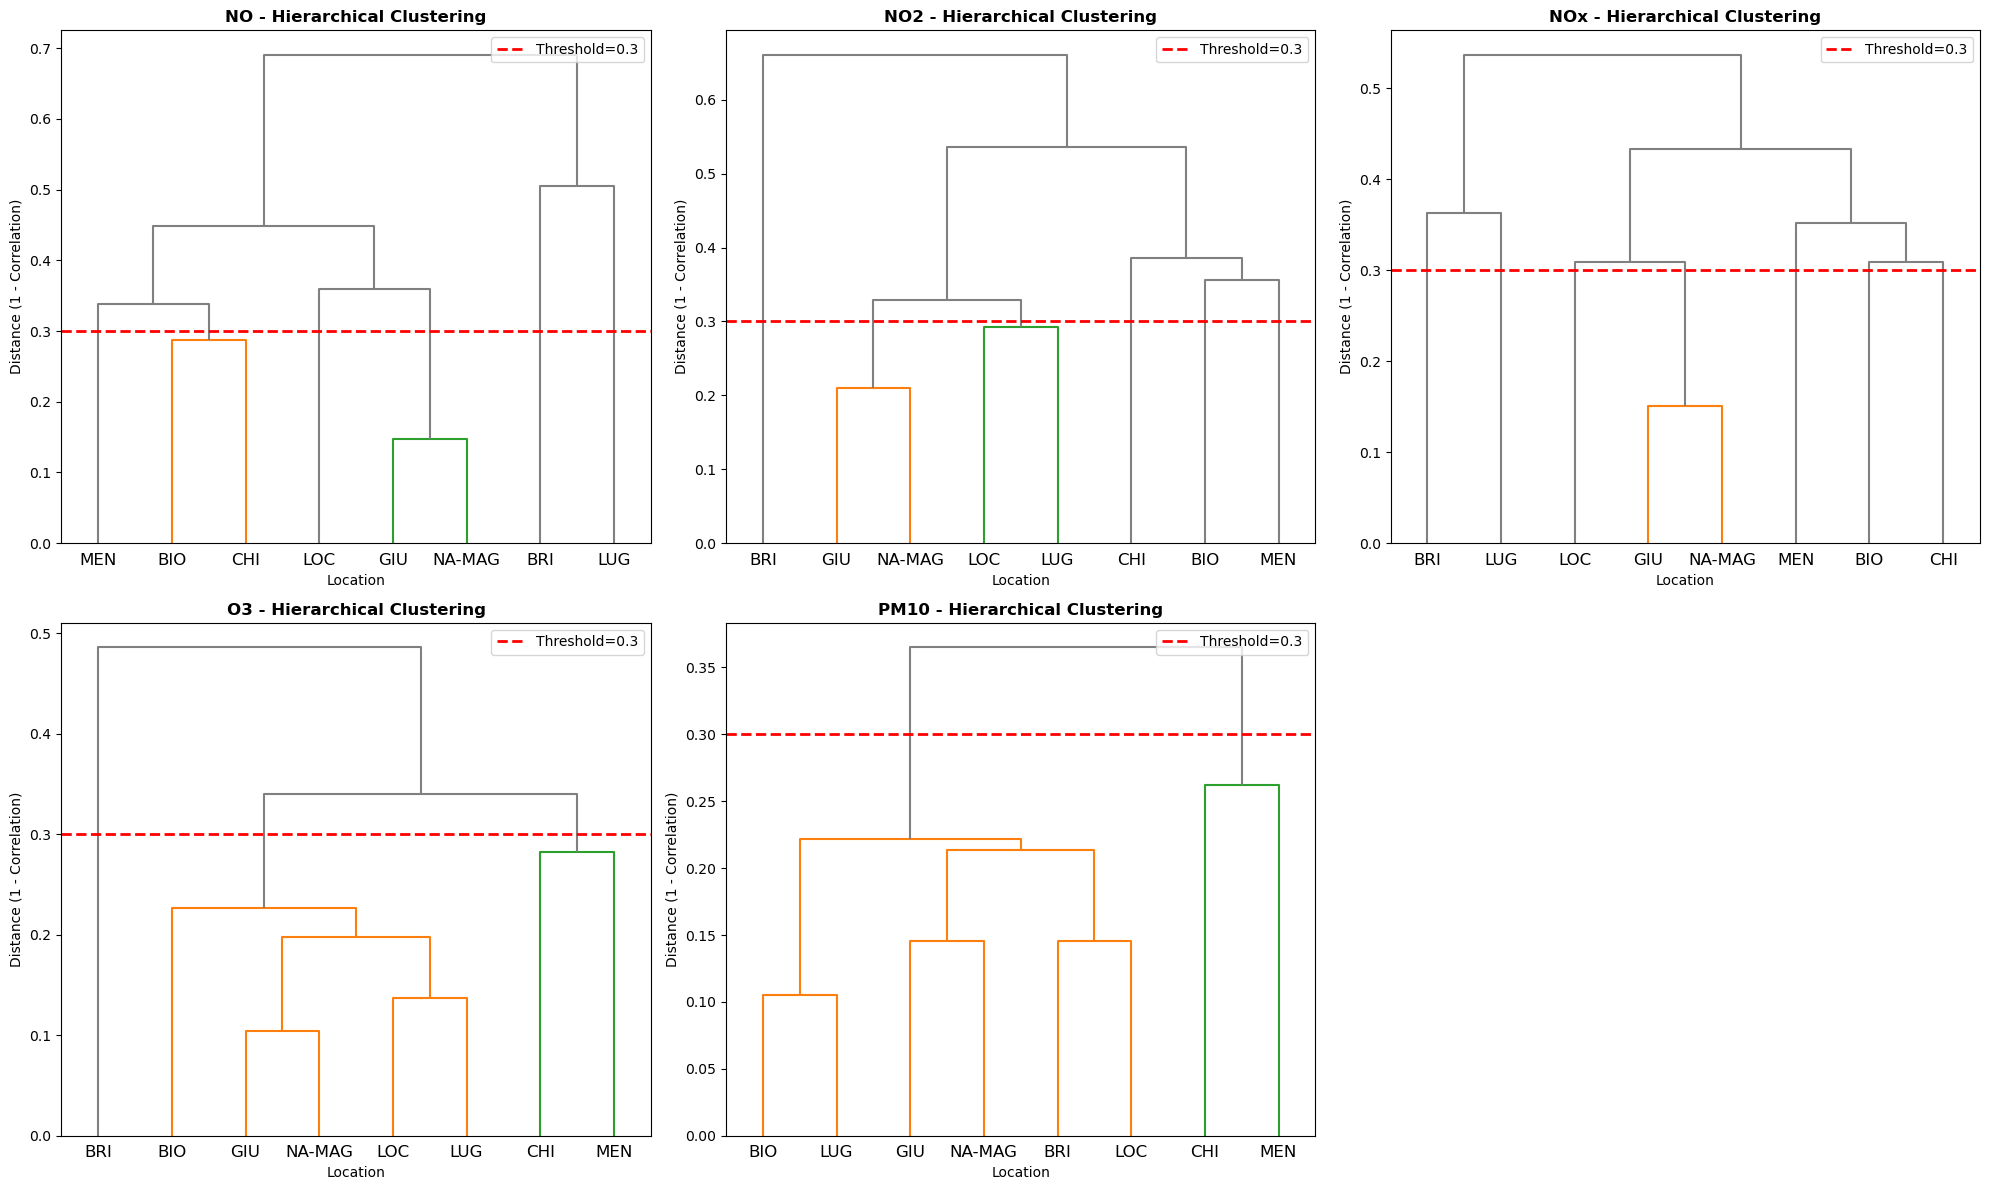


IDENTIFIED CLUSTERS (threshold = 0.3):

NO:
  Cluster 1: ['BIO', 'CHI']
  Cluster 2: ['MEN']
  Cluster 3: ['GIU', 'NA-MAG']
  Cluster 4: ['LOC']
  Cluster 5: ['BRI']
  Cluster 6: ['LUG']

NO2:
  Cluster 1: ['GIU', 'NA-MAG']
  Cluster 2: ['LOC', 'LUG']
  Cluster 3: ['BIO']
  Cluster 4: ['MEN']
  Cluster 5: ['CHI']
  Cluster 6: ['BRI']

NOx:
  Cluster 1: ['BRI']
  Cluster 2: ['LUG']
  Cluster 3: ['GIU', 'NA-MAG']
  Cluster 4: ['LOC']
  Cluster 5: ['BIO']
  Cluster 6: ['CHI']
  Cluster 7: ['MEN']

O3:
  Cluster 1: ['BIO', 'GIU', 'LOC', 'LUG', 'NA-MAG']
  Cluster 2: ['CHI', 'MEN']
  Cluster 3: ['BRI']

PM10:
  Cluster 1: ['BIO', 'BRI', 'GIU', 'LOC', 'LUG', 'NA-MAG']
  Cluster 2: ['CHI', 'MEN']

CONSENSUS ANALYSIS ACROSS FEATURES:

Location pairs co-occurring in same cluster:
  GIU-NA-MAG: 5/5 features
  LOC-LUG: 3/5 features
  BIO-GIU: 2/5 features
  BIO-LOC: 2/5 features
  BIO-LUG: 2/5 features
  BIO-NA-MAG: 2/5 features
  CHI-MEN: 2/5 features
  GIU-LOC: 2/5 features
  GIU-LUG: 2/5 feat

In [23]:
# Justify location grouping using hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from collections import defaultdict

print("="*80)
print("LOCATION GROUPING - HIERARCHICAL CLUSTERING APPROACH")
print("="*80)

# Use all common features for clustering analysis
features_to_analyze = sorted(list(common_features))
print(f"Analyzing {len(features_to_analyze)} common features: {features_to_analyze}")

# Calculate grid size for subplots
n_features = len(features_to_analyze)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

# Store cluster assignments for each feature
all_cluster_assignments = {}

for idx, feat in enumerate(features_to_analyze):
    ax = axes[idx]
    
    # Get columns for this feature across all locations
    feat_cols = [f"{loc}__{feat}__m0" for loc in locations if f"{loc}__{feat}__m0" in X_train.columns]
    
    if not feat_cols:
        ax.set_visible(False)
        continue
    
    # Calculate correlation matrix
    corr_matrix = X_train[feat_cols].corr()
    
    # Convert correlation to distance (1 - correlation)
    distance_matrix = 1 - corr_matrix
    condensed_dist = squareform(distance_matrix)
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(condensed_dist, method='average')
    
    # Create dendrogram
    loc_labels = [col.split('__')[0] for col in feat_cols]
    dendrogram(linkage_matrix, labels=loc_labels, ax=ax, 
               color_threshold=0.3, above_threshold_color='gray')
    
    ax.set_title(f'{feat} - Hierarchical Clustering', fontsize=12, fontweight='bold')
    ax.set_xlabel('Location', fontsize=10)
    ax.set_ylabel('Distance (1 - Correlation)', fontsize=10)
    ax.axhline(y=0.3, color='red', linestyle='--', linewidth=2, label='Threshold=0.3')
    ax.legend()
    
    # Extract clusters for this feature
    threshold = 0.3
    clusters = fcluster(linkage_matrix, threshold, criterion='distance')
    all_cluster_assignments[feat] = dict(zip(loc_labels, clusters))

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

# Print identified clusters per feature
print("\n" + "="*80)
print("IDENTIFIED CLUSTERS (threshold = 0.3):")
print("="*80)

for feat in features_to_analyze:
    if feat not in all_cluster_assignments:
        continue
    
    print(f"\n{feat}:")
    cluster_dict = {}
    for loc, cluster_id in all_cluster_assignments[feat].items():
        if cluster_id not in cluster_dict:
            cluster_dict[cluster_id] = []
        cluster_dict[cluster_id].append(loc)
    
    for cluster_id, locs in sorted(cluster_dict.items()):
        print(f"  Cluster {cluster_id}: {locs}")

# Find consensus grouping: count how often each pair co-occurs
print("\n" + "="*80)
print("CONSENSUS ANALYSIS ACROSS FEATURES:")
print("="*80)

location_pairs = {}
for loc1 in locations:
    for loc2 in locations:
        if loc1 < loc2:
            location_pairs[(loc1, loc2)] = 0

# Count co-occurrences
for feat, assignments in all_cluster_assignments.items():
    cluster_dict = {}
    for loc, cluster_id in assignments.items():
        if cluster_id not in cluster_dict:
            cluster_dict[cluster_id] = []
        cluster_dict[cluster_id].append(loc)
    
    for locs in cluster_dict.values():
        for i, loc1 in enumerate(locs):
            for loc2 in locs[i+1:]:
                pair = tuple(sorted([loc1, loc2]))
                if pair in location_pairs:
                    location_pairs[pair] += 1

# Show pairs that cluster together consistently
print("\nLocation pairs co-occurring in same cluster:")
for pair, count in sorted(location_pairs.items(), key=lambda x: x[1], reverse=True):
    if count > 0:
        print(f"  {pair[0]}-{pair[1]}: {count}/{len(features_to_analyze)} features")

# Derive final groups from consensus
# Use locations that consistently cluster together (2+ features, or 50% of features)
from collections import defaultdict
location_graph = defaultdict(set)

min_cooccurrence = max(2, len(features_to_analyze) // 2)  # At least 2 or 50% of features
print(f"\nUsing minimum co-occurrence threshold: {min_cooccurrence} features")

for (loc1, loc2), count in location_pairs.items():
    if count >= min_cooccurrence:
        location_graph[loc1].add(loc2)
        location_graph[loc2].add(loc1)

# Find connected components (groups)
visited = set()
final_groups = []

def dfs(loc, group):
    visited.add(loc)
    group.add(loc)
    for neighbor in location_graph[loc]:
        if neighbor not in visited:
            dfs(neighbor, group)

for loc in locations:
    if loc not in visited:
        group = set()
        dfs(loc, group)
        if group:
            final_groups.append(sorted(group))

print("\n" + "="*80)
print("FINAL PROPOSED GROUPING (derived from clustering):")
print("="*80)
for i, group in enumerate(final_groups, 1):
    print(f"  Group {i}: {group}")
print("="*80)

# Save for later use
location_groups = {f'group{i+1}': group for i, group in enumerate(final_groups)}

Validating grouping with 5 common features


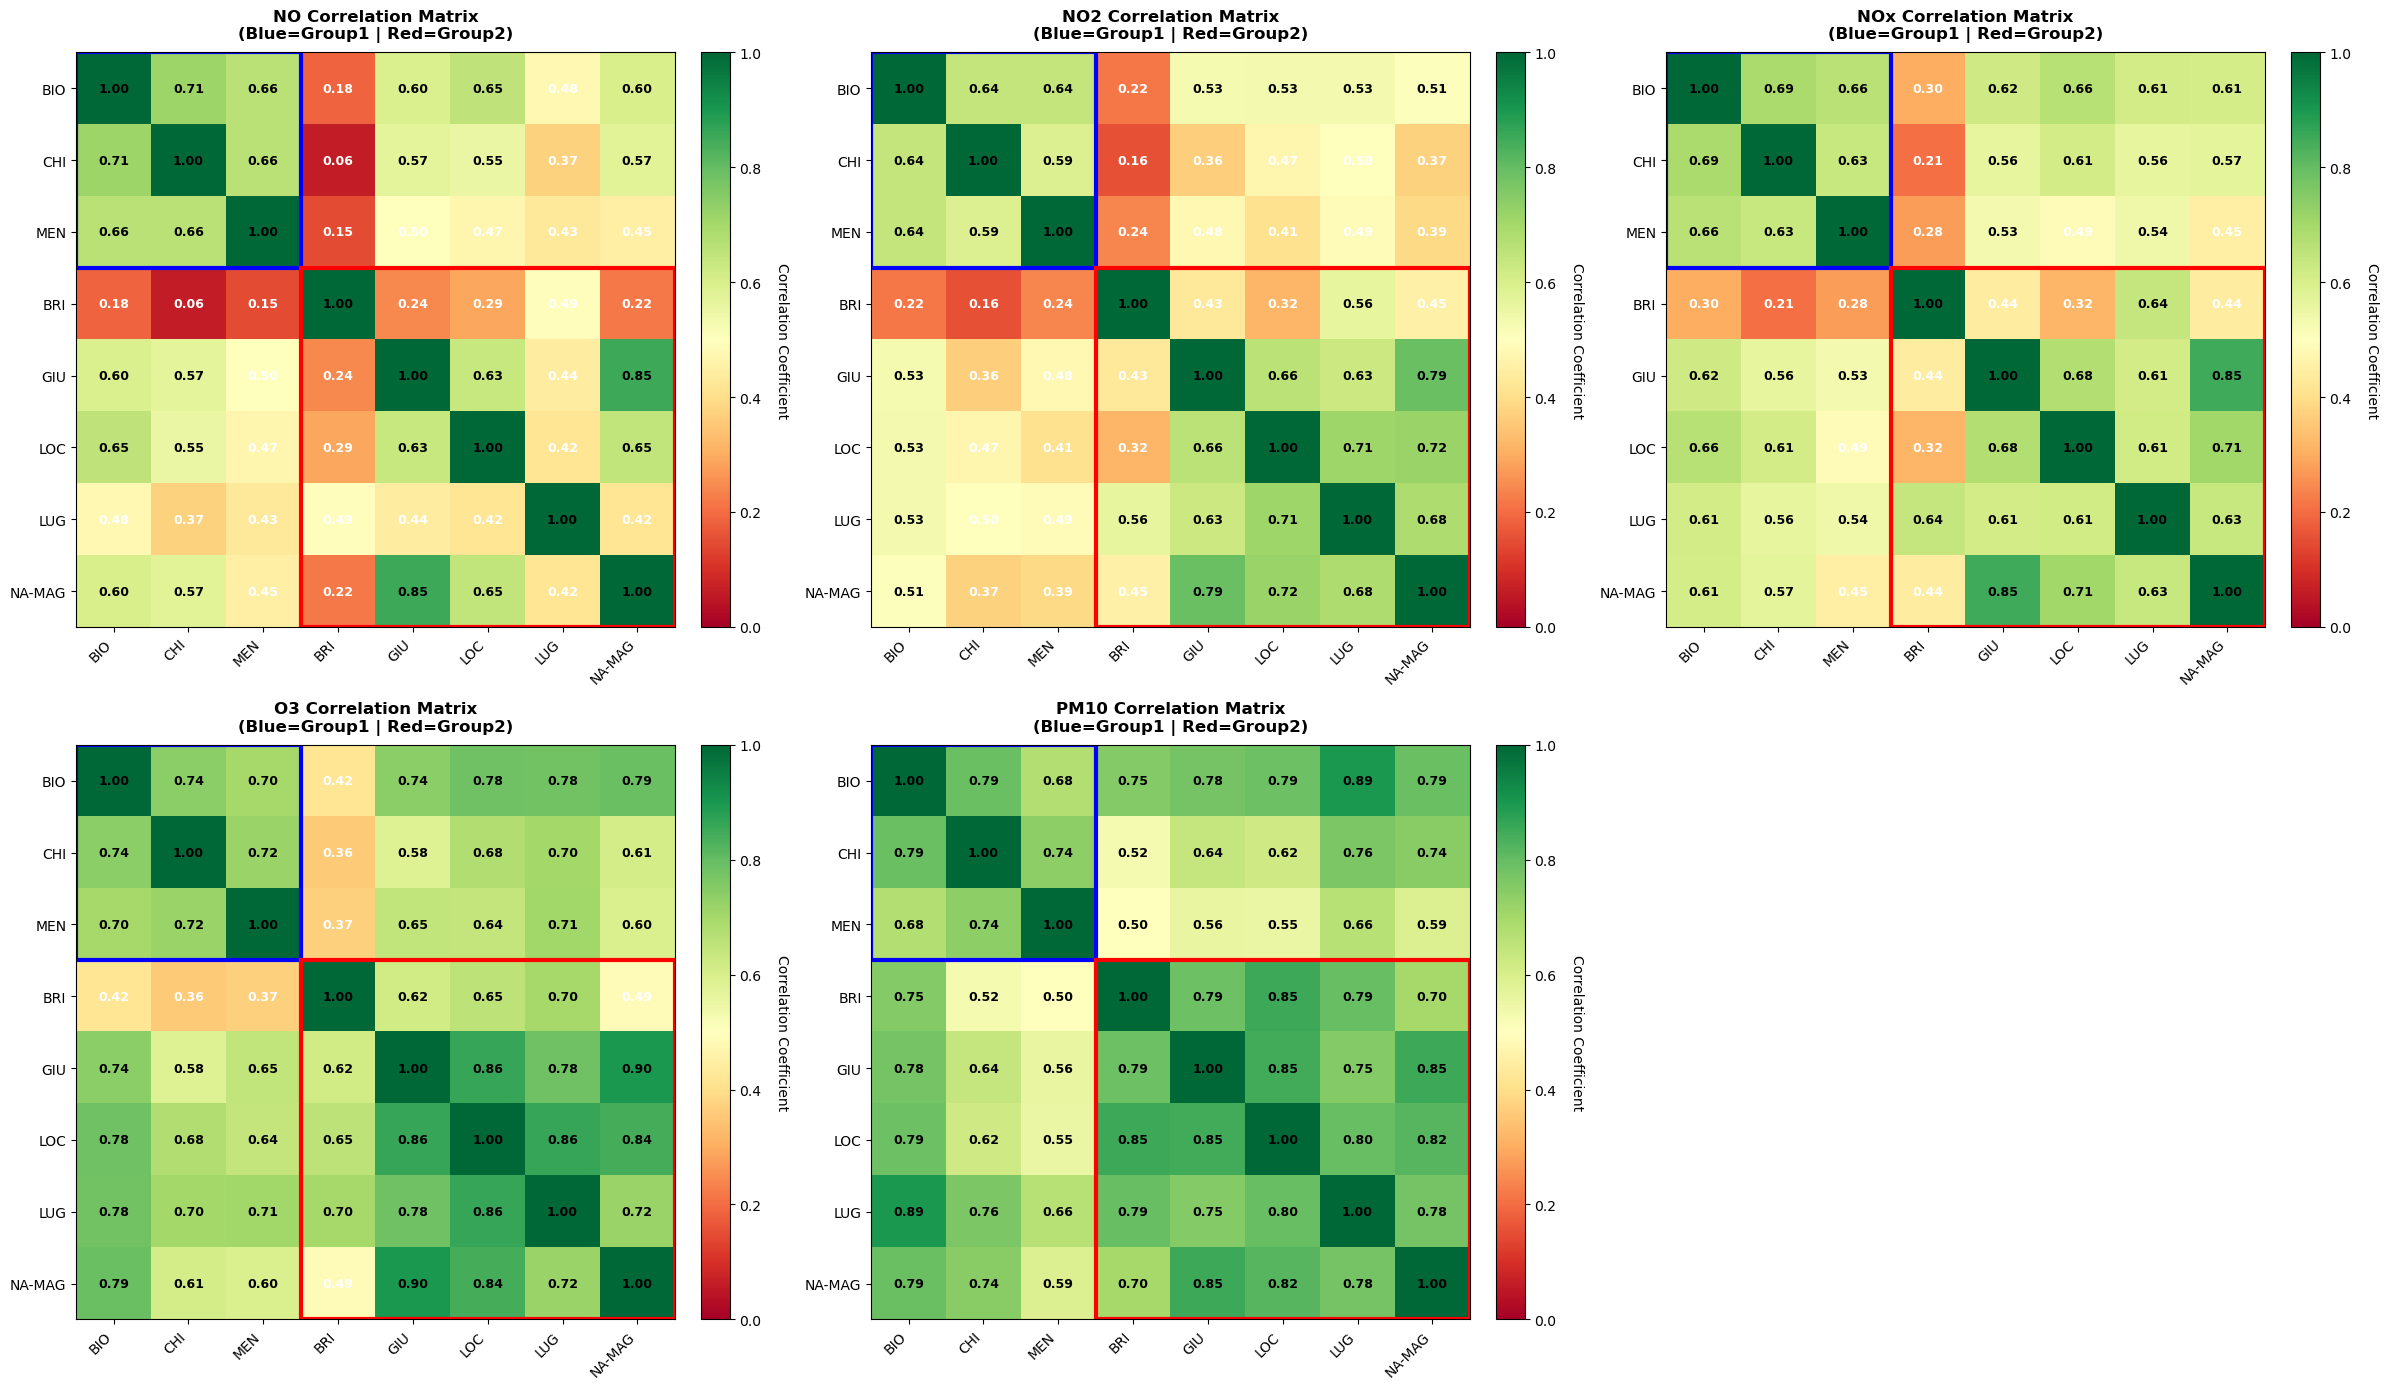

In [24]:
# Verify grouping with heatmaps showing correlation within/across groups
from matplotlib.patches import Rectangle

# Use the groups derived from clustering (or define manually if needed)
# Note: location_groups should already be defined from the previous cell
# If not, uncomment the following:
location_groups = {
    'group1': ['BIO', 'CHI', 'MEN'],
    'group2': ['BRI', 'GIU', 'LOC', 'LUG', 'NA-MAG']
}

# Create heatmaps for all common features
features_for_validation = sorted(list(common_features))
print(f"Validating grouping with {len(features_for_validation)} common features")

# Calculate grid size for subplots
n_features = len(features_for_validation)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 7 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for idx, feat in enumerate(features_for_validation):
    ax = axes[idx]
    
    # Get feature columns for all locations
    feat_cols = [f"{loc}__{feat}__m0" for loc in locations if f"{loc}__{feat}__m0" in X_train.columns]
    
    if not feat_cols:
        ax.set_visible(False)
        continue
    
    # Calculate correlation matrix
    corr_matrix = X_train[feat_cols].corr()
    
    # Reorder to group locations together
    ordered_locs = location_groups['group1'] + location_groups['group2']
    ordered_cols = [f"{loc}__{feat}__m0" for loc in ordered_locs if f"{loc}__{feat}__m0" in feat_cols]
    corr_matrix = corr_matrix.loc[ordered_cols, ordered_cols]
    
    # Create heatmap
    im = ax.imshow(corr_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    
    # Set ticks
    loc_labels = [col.split('__')[0] for col in ordered_cols]
    ax.set_xticks(np.arange(len(ordered_cols)))
    ax.set_yticks(np.arange(len(ordered_cols)))
    ax.set_xticklabels(loc_labels, fontsize=10, rotation=45, ha='right')
    ax.set_yticklabels(loc_labels, fontsize=10)
    
    # Add text annotations
    for i in range(len(ordered_cols)):
        for j in range(len(ordered_cols)):
            text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                          ha="center", va="center", 
                          color="white" if corr_matrix.iloc[i, j] < 0.5 else "black",
                          fontsize=9, fontweight='bold')
    
    # Draw rectangles around groups
    n_group1 = len([loc for loc in location_groups['group1'] if f"{loc}__{feat}__m0" in feat_cols])
    
    # Group 1 rectangle (top-left)
    rect1 = Rectangle((-0.5, -0.5), n_group1, n_group1, 
                      linewidth=3, edgecolor='blue', facecolor='none', label='Group 1')
    ax.add_patch(rect1)
    
    # Group 2 rectangle (bottom-right)
    rect2 = Rectangle((n_group1-0.5, n_group1-0.5), 
                      len(ordered_cols)-n_group1, len(ordered_cols)-n_group1,
                      linewidth=3, edgecolor='red', facecolor='none', label='Group 2')
    ax.add_patch(rect2)
    
    ax.set_title(f'{feat} Correlation Matrix\n(Blue=Group1 | Red=Group2)', 
                 fontsize=12, fontweight='bold', pad=10)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20)

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()




In [25]:
# Setup for imputation
from sklearn.impute import KNNImputer

print("="*80)
print("MISSING VALUE IMPUTATION - SETUP")
print("="*80)

# Create copies to avoid modifying original data
X_train_imputed = X_train.copy()
y_train_imputed = y_train.copy()

print("\nInitial missing values:")
print(f"  Features: {X_train_imputed.isnull().sum().sum()}")
print(f"  Targets:  {y_train_imputed.isnull().sum().sum()}")

MISSING VALUE IMPUTATION - SETUP

Initial missing values:
  Features: 52231
  Targets:  192


In [26]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# At the top of the imputation cell
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [27]:
# Step 1: Impute common features (m0) using spatial grouping with Random Forest
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

print("="*80)
print("STEP 1: IMPUTING COMMON FEATURES (m0) WITH SPATIAL GROUPING")
print("="*80)

for feat in sorted(common_features):
    print(f"\nProcessing {feat}...")
    
    for group_name, group_locs in location_groups.items():
        # Get columns for this feature and group
        group_cols = [f"{loc}__{feat}__m0" for loc in group_locs 
                     if f"{loc}__{feat}__m0" in X_train_imputed.columns]
        
        if not group_cols:
            continue
        
        # Count missing values before imputation
        missing_before = X_train_imputed[group_cols].isnull().sum().sum()
        
        if missing_before == 0:
            print(f"  {group_name}: No missing values")
            continue
        
        # Use Random Forest imputation within the group
        rf_imputer = IterativeImputer(
            estimator=RandomForestRegressor(n_estimators=10, random_state=42, max_depth=10),
            max_iter=20,
            random_state=42
        )
        X_train_imputed[group_cols] = rf_imputer.fit_transform(X_train_imputed[group_cols])
        
        # Count missing values after imputation
        missing_after = X_train_imputed[group_cols].isnull().sum().sum()
        print(f"  {group_name}: {missing_before} → {missing_after} missing values")

print(f"\nTotal missing in features after step 1: {X_train_imputed.isnull().sum().sum()}")

STEP 1: IMPUTING COMMON FEATURES (m0) WITH SPATIAL GROUPING

Processing NO...
  group1: 8 → 0 missing values
  group2: 23 → 0 missing values

Processing NO2...
  group1: 8 → 0 missing values
  group2: 23 → 0 missing values

Processing NOx...
  group1: 8 → 0 missing values
  group2: 23 → 0 missing values

Processing O3...
  group1: 13 → 0 missing values
  group2: 33 → 0 missing values

Processing PM10...
  group1: 20 → 0 missing values
  group2: 55 → 0 missing values

Total missing in features after step 1: 52017


No, since we have the m(0) measurements for all the features we can recalculate the lags after imputation.

In [30]:
# Step 2: Drop existing lagged features and recalculate from imputed m0 values
print("="*80)
print("STEP 2: DROPPING OLD LAGS AND RECALCULATING FROM IMPUTED m0 VALUES")
print("="*80)

# Collect all new lag columns in a list, then concat once
new_lag_columns = {}

for feat in sorted(common_features):
    print(f"\nProcessing {feat}...")
    
    for loc in locations:
        # Get the m0 column for this location/feature
        m0_col = f"{loc}__{feat}__m0"
        
        if m0_col not in X_train_imputed.columns:
            continue
        
        # Drop old lagged columns (m1 to m20)
        old_lag_cols = [f"{loc}__{feat}__m{lag}" for lag in range(1, 21) 
                       if f"{loc}__{feat}__m{lag}" in X_train_imputed.columns]
        
        if old_lag_cols:
            X_train_imputed.drop(columns=old_lag_cols, inplace=True)
            print(f"  {loc}: Dropped {len(old_lag_cols)} old lag columns")
        
        # Get imputed m0 values
        m0_values = X_train_imputed[m0_col]
        
        # Create all lags for this feature/location at once
        for lag in range(1, 21):
            lag_col = f"{loc}__{feat}__m{lag}"
            new_lag_columns[lag_col] = m0_values.shift(lag)
                
        print(f"  {loc}: Recalculated m1-m20 from imputed m0")

# Concatenate all new lag columns at once (much faster!)
print("\nAdding all recalculated lag columns to dataframe...")
X_train_imputed = pd.concat([X_train_imputed, pd.DataFrame(new_lag_columns, index=X_train_imputed.index)], axis=1)

print(f"\nTotal missing in features after step 2: {X_train_imputed.isnull().sum().sum()}")
print("(Remaining NaNs are expected at the beginning due to lag creation)")

STEP 2: DROPPING OLD LAGS AND RECALCULATING FROM IMPUTED m0 VALUES

Processing NO...
  BIO: Dropped 20 old lag columns
  BIO: Recalculated m1-m20 from imputed m0
  BRI: Dropped 20 old lag columns
  BRI: Recalculated m1-m20 from imputed m0
  CHI: Dropped 20 old lag columns
  CHI: Recalculated m1-m20 from imputed m0
  GIU: Dropped 20 old lag columns
  GIU: Recalculated m1-m20 from imputed m0
  LOC: Dropped 20 old lag columns
  LOC: Recalculated m1-m20 from imputed m0
  LUG: Dropped 20 old lag columns
  LUG: Recalculated m1-m20 from imputed m0
  MEN: Dropped 20 old lag columns
  MEN: Recalculated m1-m20 from imputed m0
  NA-MAG: Dropped 20 old lag columns
  NA-MAG: Recalculated m1-m20 from imputed m0

Processing NO2...
  BIO: Dropped 20 old lag columns
  BIO: Recalculated m1-m20 from imputed m0
  BRI: Dropped 20 old lag columns
  BRI: Recalculated m1-m20 from imputed m0
  CHI: Dropped 20 old lag columns
  CHI: Recalculated m1-m20 from imputed m0
  GIU: Dropped 20 old lag columns
  GIU: Re

In [ ]:
# top correlations for forecast features with target

FORECAST FEATURES ANALYSIS

Total forecast features: 4576
Total measurement features: 3912

Average missingness:
  Forecasts: 0.17%
  Measurements: 0.32%

FORECAST CORRELATION WITH PM10 TARGETS

Sample correlations (d0 target):

Top forecast features:
  CLCT: -0.216
  CLCT: -0.195
  CLCT: -0.174
  CLCT: -0.148
  CLCT: -0.129

Top measurement features (m0):
  PM10: 0.701
  NO: 0.464
  NO2: 0.347
  NOx: 0.482
  O3: -0.408

RECOMMENDATION

Forecasts are likely USEFUL for:
- Multi-day ahead predictions (d1-d5): Weather forecasts provide future information
- Capturing weather-pollution relationships (e.g., rain washes PM10, wind disperses it)

Forecasts may be LESS USEFUL if:
- High missingness (>30%)
- Low correlation with targets
- Measurements already capture temporal patterns via lags

SUGGESTED APPROACH:
1. Train baseline model with measurements only
2. Train model with measurements + forecasts
3. Compare performance to justify added complexity

